In [1]:
import numpy             as np
import gvar              as gv
import matplotlib.pyplot as plt
import lsqfit

In [2]:
from b2heavy import FnalHISQMetadata

In [3]:
from b2heavy.TwoPointFunctions.utils     import correlation_diagnostics
from b2heavy.TwoPointFunctions.types2pts import CorrelatorIO, plot_effective_coeffs
from b2heavy.TwoPointFunctions.fitter    import StagFitter

In [4]:
from b2heavy.ThreePointFunctions.types3pts  import Ratio, RatioIO
from b2heavy.ThreePointFunctions.fitter3pts import RatioFitter

Select a case for which we want to calculate the recoil parameter

In [5]:
ENSEMBLE = 'Coarse-1'
DATA_DIR = '/Users/pietro/code/data_analysis/BtoD/Alex/'

BINSIZE  = {
    'MediumCoarse':13,
    'Coarse-2':    16,
    'Coarse-1':    11,
    'Coarse-Phys': 19,
    'Fine-1':      16,
    'Fine-Phys':   16,
    'SuperFine':   22
}

COV_SPECS = dict(
    diag   = False,
    block  = False,
    scale  = True,
    shrink = True,
    cutsvd = 0.01
)

In [6]:
mdata = FnalHISQMetadata.params(ENSEMBLE)
LVOL   = mdata['L']
alphas = mdata['alphaS'] 

## Two-pts functions

In [7]:
MESON      = 'Dst'
SMSLIST  = ['1S-1S','d-d','d-1S']
# MOM_LIST   = ['000','100','200','300','110','211']
MOM_LIST   = ['000','100']
TRANGE_EFF = {
    'Coarse-1': {
        '000': (13,20),
        '100': (13,20),
        '200': (13,20),
        '300': (10,17),
        '110': (11,19),
        '211': (11,19)
    }
}
TRANGE     = {
    'Coarse-1': {
        '000': (5,26),
        '100': (5,23),
        '200': (5,21),
        '300': (5,17),
        '110': (5,23),
        '211': (5,19)
    }
}

In [8]:
fits = {}
for mom in MOM_LIST:
    print(f'{ mom = :-^20}')

    io   = CorrelatorIO(ENSEMBLE,MESON,mom,PathToDataDir=DATA_DIR)
    stag = StagFitter(
        io       = io,
        jkBin    = BINSIZE[ENSEMBLE],
        smearing = SMSLIST
    )

    effm,effa = stag.meff(
        TRANGE_EFF[ENSEMBLE][mom],
        **COV_SPECS
    )

    fits[mom] = stag.fit(
        Nstates = 3,
        trange  = TRANGE[ENSEMBLE][mom],
        **COV_SPECS
    )

 mom = --------000---------
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


/Users/pietro/code/software/B2heavy/b2heavy/TwoPointFunctions/types2pts.py:38: RuntimeWarning: invalid value encountered in sqrt
  m = np.arccosh( (y[(it+1)%len(y)]+y[(it-1)%len(y)])/y[it]/2 )
/Users/pietro/code/software/B2heavy/b2heavy/TwoPointFunctions/types2pts.py:38: RuntimeWarning: invalid value encountered in log
  m = np.arccosh( (y[(it+1)%len(y)]+y[(it-1)%len(y)])/y[it]/2 )
/Users/pietro/code/software/B2heavy/b2heavy/TwoPointFunctions/types2pts.py:38: RuntimeWarning: invalid value encountered in arccosh
  m = np.arccosh( (y[(it+1)%len(y)]+y[(it-1)%len(y)])/y[it]/2 )


 mom = --------100---------


/Users/pietro/code/software/B2heavy/b2heavy/TwoPointFunctions/types2pts.py:38: RuntimeWarning: invalid value encountered in sqrt
  m = np.arccosh( (y[(it+1)%len(y)]+y[(it-1)%len(y)])/y[it]/2 )
/Users/pietro/code/software/B2heavy/b2heavy/TwoPointFunctions/types2pts.py:38: RuntimeWarning: invalid value encountered in log
  m = np.arccosh( (y[(it+1)%len(y)]+y[(it-1)%len(y)])/y[it]/2 )
/Users/pietro/code/software/B2heavy/b2heavy/TwoPointFunctions/types2pts.py:38: RuntimeWarning: invalid value encountered in arccosh
  m = np.arccosh( (y[(it+1)%len(y)]+y[(it-1)%len(y)])/y[it]/2 )


In [9]:
if True:
    params = {}
    for mom in MOM_LIST:
        print(f'{ mom = :-^20}')

        io   = CorrelatorIO(ENSEMBLE,MESON,mom,PathToDataDir=DATA_DIR)
        stag = StagFitter(
            io       = io,
            jkBin    = BINSIZE[ENSEMBLE],
            smearing = SMSLIST
        )

        effm,effa = stag.meff(
            TRANGE_EFF[ENSEMBLE][mom],
            **COV_SPECS
        )

        jk = stag.fit(
            Nstates = 3,
            trange  = TRANGE[ENSEMBLE][mom],
            jkfit   = True,
            **COV_SPECS
        )

        params[mom] = jk

    for m in params:
        np.save(f'jkfit_{m}.npy',np.asarray(params[m]))

 mom = --------000---------


/Users/pietro/code/software/B2heavy/b2heavy/TwoPointFunctions/types2pts.py:38: RuntimeWarning: invalid value encountered in sqrt
  m = np.arccosh( (y[(it+1)%len(y)]+y[(it-1)%len(y)])/y[it]/2 )
/Users/pietro/code/software/B2heavy/b2heavy/TwoPointFunctions/types2pts.py:38: RuntimeWarning: invalid value encountered in log
  m = np.arccosh( (y[(it+1)%len(y)]+y[(it-1)%len(y)])/y[it]/2 )
/Users/pietro/code/software/B2heavy/b2heavy/TwoPointFunctions/types2pts.py:38: RuntimeWarning: invalid value encountered in arccosh
  m = np.arccosh( (y[(it+1)%len(y)]+y[(it-1)%len(y)])/y[it]/2 )
100%|██████████| 90/90 [00:18<00:00,  4.90it/s]


 mom = --------100---------


/Users/pietro/code/software/B2heavy/b2heavy/TwoPointFunctions/types2pts.py:38: RuntimeWarning: invalid value encountered in sqrt
  m = np.arccosh( (y[(it+1)%len(y)]+y[(it-1)%len(y)])/y[it]/2 )
/Users/pietro/code/software/B2heavy/b2heavy/TwoPointFunctions/types2pts.py:38: RuntimeWarning: invalid value encountered in log
  m = np.arccosh( (y[(it+1)%len(y)]+y[(it-1)%len(y)])/y[it]/2 )
/Users/pietro/code/software/B2heavy/b2heavy/TwoPointFunctions/types2pts.py:38: RuntimeWarning: invalid value encountered in arccosh
  m = np.arccosh( (y[(it+1)%len(y)]+y[(it-1)%len(y)])/y[it]/2 )
100%|██████████| 90/90 [00:38<00:00,  2.32it/s]


## Three-pts functions

In [10]:
MOM    = '100'
SMLIST = ['1S']

Nstates = 1
trange  = (3,11)

### Recoil parameter

First we need to calculate the recoil parameter defined by
$$
    w = \frac{1+x_f^2}{1-x_f^2}
$$

In [24]:
RATIO  = 'xfstpar'

io = RatioIO(ENSEMBLE,RATIO,MOM,PathToDataDir=DATA_DIR)
ratio = RatioFitter(
    io,
    jkBin    = BINSIZE[ENSEMBLE],
    smearing = SMLIST
)

In [25]:
x,y = ratio.format()

Kpr    = gv.gvar(y['1S'][x.tolist().index(ratio.Ta//2)].mean,0.05)
dE_src = gv.gvar(
    params[MOM]['E'][:,2].mean(),
    np.sqrt(params[MOM]['E'][:,2].var())*3
)

priors = ratio.priors(Nstates,K=Kpr)

In [26]:
fit = ratio.fit(
    Nstates = Nstates,
    trange  = trange,
    priors  = ratio.priors(Nstates,K=Kpr),
    **COV_SPECS
)

pr = fit.prior
popt = dict(fit.pmean)
fcov = gv.evalcov(fit.y)
c2,ce,p = ratio.chi2exp(Nstates,trange,popt,fcov)

print(f'{c2/ce = }')
print(f'{p = }')

Least Square Fit:
  chi2/dof [dof] = 0.4 [9]    Q = 0.94    logGBF = 35.437

Parameters:
        ratio 0   -0.086 (25)     [ -0.074 (50) ]  
       dE_src 0    -1.38 (85)     [  -1.5 (1.0) ]  
         A_1S 0    -0.57 (20)     [     0 ± 1.0 ]  
         B_1S 0    -0.23 (22)     [     0 ± 1.0 ]  

Settings:
  svdcut/n = 0/0    tol = (1e-08,1e-10,1e-10*)    (itns/time = 16/0.0)
  fitter = scipy_least_squares    method = trf

c2/ce = Array(0.76412095, dtype=float64)
p = 0.5712


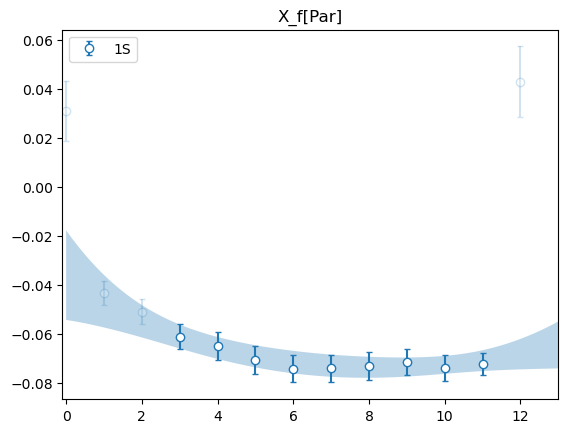

In [30]:
fig, ax = plt.subplots()
ratio.plot_fit(ax,Nstates,trange)
plt.title('X_f[Par]')
plt.show()

In [14]:
fit = ratio.fit(
    Nstates = Nstates,
    trange  = trange,
    priors  = ratio.priors(Nstates,K=Kpr),
    jkfit   = True,
    **COV_SPECS
)

Least Square Fit:
  chi2/dof [dof] = 0.4 [9]    Q = 0.94    logGBF = 35.437

Parameters:
        ratio 0   -0.086 (25)     [ -0.074 (50) ]  
       dE_src 0    -1.38 (85)     [  -1.5 (1.0) ]  
         A_1S 0    -0.57 (20)     [     0 ± 1.0 ]  
         B_1S 0    -0.23 (22)     [     0 ± 1.0 ]  

Settings:
  svdcut/n = 0/0    tol = (1e-08,1e-10,1e-10*)    (itns/time = 16/0.0)
  fitter = scipy_least_squares    method = trf



100%|██████████| 90/90 [00:00<00:00, 195.06it/s]


In [15]:
xf = fit['ratio']
w_recoil = (1+xf**2)/(1-xf**2)

### $X_0$ and $X_1$

In [1]:
RATIO  = 'R0'

Zpar = params['100']['Z_1S_Par'][:,0] * np.sqrt(2*params['100']['E'][:,0])
Zbot = params['100']['Z_1S_Bot'][:,0] * np.sqrt(2*params['100']['E'][:,0])


io = RatioIO(ENSEMBLE,RATIO,MOM,PathToDataDir=DATA_DIR)
ratio = RatioFitter(
    io,
    jkBin    = BINSIZE[ENSEMBLE],
    smearing = SMLIST,
    Zpar = Zpar,
    Zbot = Zbot
)

NameError: name 'params' is not defined

In [33]:
x,y = ratio.format()

Kpr    = gv.gvar(y['1S'][x.tolist().index(ratio.Ta//2)].mean,0.05)
dE_src = gv.gvar(
    params[MOM]['E'][:,2].mean(),
    np.sqrt(params[MOM]['E'][:,2].var())*3
)

priors = ratio.priors(Nstates,K=Kpr)

In [34]:
fit = ratio.fit(
    Nstates = Nstates,
    trange  = trange,
    priors  = ratio.priors(Nstates,K=Kpr),
    **COV_SPECS
)

pr = fit.prior
popt = dict(fit.pmean)
fcov = gv.evalcov(fit.y)
c2,ce,p = ratio.chi2exp(Nstates,trange,popt,fcov)

print(f'{c2/ce = }')
print(f'{p = }')

Least Square Fit:
  chi2/dof [dof] = 0.63 [9]    Q = 0.77    logGBF = 39.421

Parameters:
        ratio 0   -0.075 (24)     [ -0.051 (50) ]  
       dE_src 0    -1.97 (81)     [  -1.5 (1.0) ]  
       dE_snk 0    -0.86 (72)     [  -1.5 (1.0) ]  
         A_1S 0    -0.64 (14)     [     0 ± 1.0 ]  
         B_1S 0    -0.39 (12)     [     0 ± 1.0 ]  

Settings:
  svdcut/n = 0/0    tol = (1e-08,1e-10,1e-10*)    (itns/time = 26/0.0)
  fitter = scipy_least_squares    method = trf

c2/ce = Array(1.30228208, dtype=float64)
p = 0.2658


In [35]:
fit = ratio.fit(
    Nstates = Nstates,
    trange  = trange,
    priors  = ratio.priors(Nstates,K=Kpr),
    jkfit   = True,
    **COV_SPECS
)

Least Square Fit:
  chi2/dof [dof] = 0.63 [9]    Q = 0.77    logGBF = 39.421

Parameters:
        ratio 0   -0.075 (24)     [ -0.051 (50) ]  
       dE_src 0    -1.97 (81)     [  -1.5 (1.0) ]  
       dE_snk 0    -0.86 (72)     [  -1.5 (1.0) ]  
         A_1S 0    -0.64 (14)     [     0 ± 1.0 ]  
         B_1S 0    -0.39 (12)     [     0 ± 1.0 ]  

Settings:
  svdcut/n = 0/0    tol = (1e-08,1e-10,1e-10*)    (itns/time = 26/0.0)
  fitter = scipy_least_squares    method = trf



100%|██████████| 90/90 [00:00<00:00, 118.81it/s]


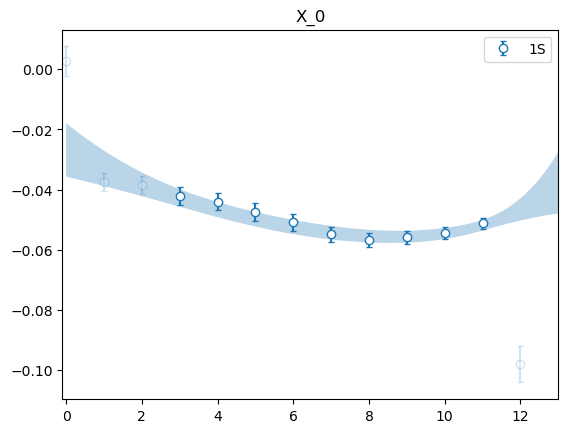

In [37]:
fig, ax = plt.subplots()
ratio.plot_fit(ax,Nstates,trange)
plt.title('X_0')
plt.show()